In [4]:
!pip install keras-tcn --no-dependencies

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [241]:
from tcn import TCN
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import numpy as np
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

mpl.rcParams['figure.figsize']=(10,8)
mpl.rcParams['axes.grid']= False

In [89]:
data=pd.read_csv('T1.csv')

In [119]:
data 

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


**Missing Values**

In [120]:
count= (data['LV ActivePower (kW)']==0).sum() # LV ActivePower is the output variable
print('the number of zero entries are=',count)  

the number of zero entries are= 0


In [121]:
data.replace(0,np.nan, inplace=True) # replacing zero with nan to implement interpolation

In [144]:
data1=data.interpolate(method='linear')

In [145]:
count= (data1['LV ActivePower (kW)']==0).sum() # LV ActivePower is the output variable
print('the number of zero entries are=',count)  

the number of zero entries are= 0


In [124]:
data1

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789
3,01 01 2018 00:30,419.645905,5.659674,516.127569,271.258087
4,01 01 2018 00:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
50525,31 12 2018 23:10,2963.980957,11.404030,3397.190793,80.502724
50526,31 12 2018 23:20,1684.353027,7.332648,1173.055771,84.062599
50527,31 12 2018 23:30,2201.106934,8.435358,1788.284755,84.742500
50528,31 12 2018 23:40,2515.694092,9.421366,2418.382503,84.297913


In [125]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


In [126]:
data1['Date/Time']=pd.to_datetime(data1['Date/Time'], infer_datetime_format=True)

In [127]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Date/Time                      50530 non-null  datetime64[ns]
 1   LV ActivePower (kW)            50530 non-null  float64       
 2   Wind Speed (m/s)               50530 non-null  float64       
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64       
 4   Wind Direction (°)             50530 non-null  float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 1.9 MB


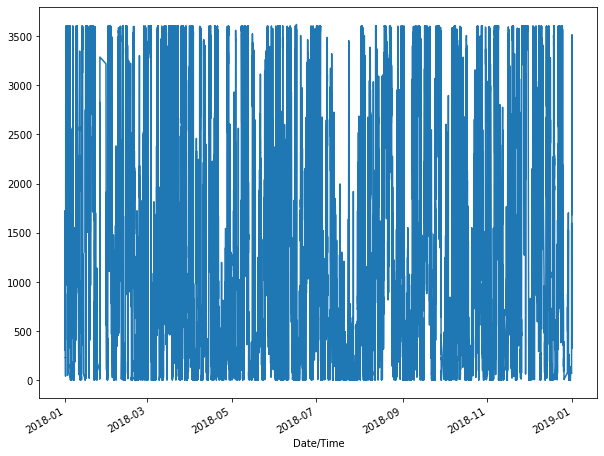

In [128]:
data1.set_index('Date/Time')['LV ActivePower (kW)'].plot()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f065de08ac0>,
      dtype=object)

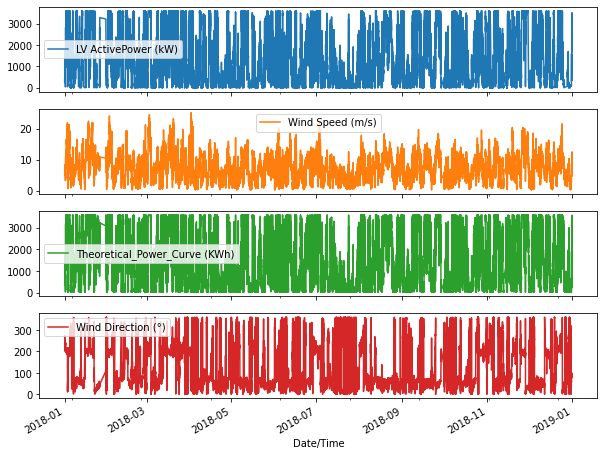

In [129]:
data1.set_index('Date/Time')[['LV ActivePower (kW)','Wind Speed (m/s)', 'Theoretical_Power_Curve (KWh)','Wind Direction (°)']].plot(subplots=True)

**Correlation between different Columns**

In [101]:
Corr1=data1['LV ActivePower (kW)'].corr(data1['Theoretical_Power_Curve (KWh)'])
Corr1


0.9598142197519528

In [102]:
Corr2=data1['LV ActivePower (kW)'].corr(data1['Wind Speed (m/s)'])
Corr2

0.9203132595981728

In [103]:
Corr3=data1['LV ActivePower (kW)'].corr(data1['Wind Direction (°)'])
Corr3

-0.06280948327199623

Negative Correlation indicate inverse relation

In [155]:
df_input = data1[['LV ActivePower (kW)','Wind Speed (m/s)','Theoretical_Power_Curve (KWh)','Wind Direction (°)']] # remove date

In [156]:
df_input

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645905,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
50525,2963.980957,11.404030,3397.190793,80.502724
50526,1684.353027,7.332648,1173.055771,84.062599
50527,2201.106934,8.435358,1788.284755,84.742500
50528,2515.694092,9.421366,2418.382503,84.297913


In [157]:
df_input.describe() # it shows that the data has some outliers

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1327.534715,7.559676,1499.834048,123.917788
std,1298.482165,4.226243,1360.283251,93.399643
min,-2.471405,0.205178,16.021926,0.015678
25%,115.482527,4.203229,168.248670,49.499437
50%,846.710602,7.105505,1064.642921,73.871109
75%,2484.386536,10.300603,2965.282435,201.762730
max,3618.732910,25.206011,3600.000000,359.997589


*Counting the outliers in dataframe*

In [158]:
count_outlier = (df_input['LV ActivePower (kW)'] > 3000).sum()
print(count_outlier)

9366


In [163]:
df_input

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645905,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
50525,2963.980957,11.404030,3397.190793,80.502724
50526,1684.353027,7.332648,1173.055771,84.062599
50527,2201.106934,8.435358,1788.284755,84.742500
50528,2515.694092,9.421366,2418.382503,84.297913


*Fixing the outliers*

In [159]:
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_input)

In [172]:
data_scaled[0:1]

array([[0.10563314, 0.2042395 , 0.11169348, 0.7222008 ]])

Features and Targets


In [164]:
features=data_scaled
targets=data_scaled[:,0]

In [219]:
features[12]

array([0.19691203, 0.25368097, 0.22562654, 0.76175281])

**Window length**

In [216]:
Window_length = 1008 # 7 days sample on hourly basis
TimeseriesGenerator(features, targets, length=Window_length, sampling_rate=6, batch_size=1)[0]

(array([[[1.05633144e-01, 2.04239502e-01, 1.11693480e-01, 7.22200804e-01],
         [1.24289347e-01, 2.23505733e-01, 1.51047363e-01, 7.39336946e-01],
         [1.96912028e-01, 2.53680967e-01, 2.25626544e-01, 7.61752810e-01],
         [2.04108680e-01, 2.48387908e-01, 2.11259924e-01, 7.25433710e-01],
         [4.13199383e-01, 3.09506631e-01, 4.13384727e-01, 7.12235042e-01],
         [3.22369093e-01, 2.75715604e-01, 2.91530184e-01, 6.53400129e-01],
         [3.08322394e-01, 2.81353577e-01, 3.10105491e-01, 6.89993901e-01],
         [2.51949115e-01, 2.67296809e-01, 2.65140344e-01, 6.55123527e-01],
         [1.62302580e-01, 2.24458422e-01, 1.53155438e-01, 6.67569983e-01],
         [2.01131846e-01, 2.39559638e-01, 1.88484526e-01, 5.55119053e-01],
         [2.43988850e-01, 2.58450572e-01, 2.39040999e-01, 6.54621275e-01],
         [6.52992720e-02, 1.73968426e-01, 6.07176857e-02, 6.50282475e-01],
         [5.43058568e-02, 1.64737815e-01, 4.73151760e-02, 6.30654787e-01],
         [9.64695126e-02,

**Training and Testing data** *by using Test Train split*

In [225]:
x_train, x_test, y_train, y_test =train_test_split(features, targets, test_size=0.20,  shuffle=False)


In [226]:
x_train[0:10]

array([[0.10563314, 0.2042395 , 0.11169348, 0.7222008 ],
       [0.1259914 , 0.21867225, 0.14059673, 0.74621926],
       [0.08528875, 0.20042766, 0.10459832, 0.75711891],
       [0.11656821, 0.21817256, 0.13953926, 0.753489  ],
       [0.10579964, 0.21490334, 0.13272432, 0.73797766],
       [0.11180352, 0.21594775, 0.13488209, 0.73493397],
       [0.12428935, 0.22350573, 0.15104736, 0.73933695],
       [0.10761989, 0.20402806, 0.11129428, 0.71651882],
       [0.12872033, 0.21517086, 0.13327529, 0.70410488],
       [0.12211327, 0.2127149 , 0.12826107, 0.71866974]])

In [227]:
x_test.shape

(10106, 4)

In [270]:
win_length=720 # from 1st january 2018 to 26 December 2018 as given in paper 72 hour forecasting
batch_size=32 
num_features= 4
sampling_rate=6
A=win_length/sampling_rate
train_generator = TimeseriesGenerator(x_train, y_train, length=win_length, sampling_rate=6, batch_size=batch_size)
test_generator = TimeseriesGenerator(x_test, y_test, length=win_length, sampling_rate=6, batch_size=batch_size)

In [271]:
train_generator

**Model Architecture**

In [274]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape = (120, num_features), return_sequences= True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.LSTM(128, return_sequences=True))
model.add(tf.keras.layers.LeakyReLU(alpha=0.5))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.LSTM(64, return_sequences=False))
model.add(tf.keras.layers.Dropout(0.3))
model.add(tf.keras.layers.Dense(1))

In [287]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_5 (TCN)                 (None, 32)                196640    
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 196,673
Trainable params: 196,673
Non-trainable params: 0
_________________________________________________________________


In [279]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=2,
                                                  mode='min')
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(),
              metrics=[tf.metrics.MeanAbsoluteError()])

history = model.fit_generator(train_generator, epochs=2,
                              validation_data=test_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

Epoch 1/2


<ipython-input-279-3302761eca3e>:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=2,


1241/1241 [==============================] - 795s 634ms/step - loss: 0.0449 - mean_absolute_error: 0.1488 - val_loss: 0.0350 - val_mean_absolute_error: 0.1433
Epoch 2/2
1241/1241 [==============================] - 791s 638ms/step - loss: 0.0267 - mean_absolute_error: 0.1126 - val_loss: 0.0310 - val_mean_absolute_error: 0.1364


In [280]:
model.evaluate_generator(test_generator, verbose=0)

<ipython-input-280-a68ec1088d46>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(test_generator, verbose=0)


[0.031042473390698433, 0.13637657463550568]

In [281]:
predictions= model.predict_generator(test_generator)

<ipython-input-281-0b0b47d602ac>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions= model.predict_generator(test_generator)


In [282]:
predictions.shape[0]

9386

In [285]:
model = keras.models.Sequential([
    TCN(input_shape=(120, 4), 
        kernel_size=10,
        nb_filters=32,
        dilations=[1, 2, 4, 8, 16],
        padding='causal',
        activation='relu',
        return_sequences=False,
        nb_stacks=2,
        use_skip_connections=False,
        use_batch_norm=False
        ),
    Dense(1, activation='linear')
])


In [286]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tcn_5 (TCN)                 (None, 32)                196640    
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 196,673
Trainable params: 196,673
Non-trainable params: 0
_________________________________________________________________


In [288]:
model.compile(optimizer='adam',
              loss='mae',
              metrics=keras.metrics.MeanAbsolutePercentageError())

history = model.fit_generator(train_generator, epochs=10,
                              validation_data=test_generator,
                              shuffle=False,
                              callbacks=[early_stopping])

Epoch 1/10


<ipython-input-288-0424998cf121>:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, epochs=10,


1241/1241 [==============================] - 326s 258ms/step - loss: 0.4876 - mean_absolute_percentage_error: 12287.1025 - val_loss: 0.1640 - val_mean_absolute_percentage_error: 733.4481
Epoch 2/10
1241/1241 [==============================] - 323s 260ms/step - loss: 0.1220 - mean_absolute_percentage_error: 5225.9067 - val_loss: 0.1179 - val_mean_absolute_percentage_error: 378.1345
Epoch 3/10
1241/1241 [==============================] - 322s 259ms/step - loss: 0.1001 - mean_absolute_percentage_error: 505.7124 - val_loss: 0.1087 - val_mean_absolute_percentage_error: 265.1525
Epoch 4/10
1241/1241 [==============================] - 306s 246ms/step - loss: 0.0925 - mean_absolute_percentage_error: 503.4001 - val_loss: 0.1070 - val_mean_absolute_percentage_error: 191.5808
Epoch 5/10
1241/1241 [==============================] - 302s 243ms/step - loss: 0.0885 - mean_absolute_percentage_error: 653.9216 - val_loss: 0.1130 - val_mean_absolute_percentage_error: 208.5097
Epoch 6/10
1241/1241 [======

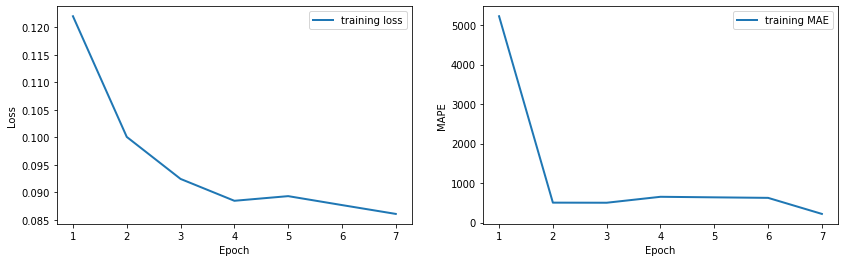

In [289]:
import matplotlib.pyplot as plt
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[1:,"loss"], lw=2, label='training loss')
#plt.plot(logs.loc[1:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[1:,"mean_absolute_percentage_error"], lw=2, label='training MAE')
#plt.plot(logs.loc[1:,"val_mean_absolute_percentage_error"], lw=2, label='validation MAE')
plt.xlabel("Epoch")
plt.ylabel("MAPE")
plt.legend(loc='upper right')
plt.show()